# 数据清洗及预处理

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
conf = (SparkConf()
            .setAppName("TestRdd") \
            .set('spark.driver.cores', '1') \
            .set('spark.executor.cores', '1') \
            .set('spark.driver.memory', '8G') \
            .set('spark.executor.memory', '8G'))
sc = SparkContext(conf=conf)
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.sql import functions as fn
from pyspark.ml import feature, regression, evaluation, Pipeline
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
from pyspark.sql import HiveContext

In [2]:
# Reading the csv file in us_acci dataframe
spark = SparkSession.builder.getOrCreate()
us_acci = spark.read.csv('US_Accidents_Dec19.csv', header = True, inferSchema = True)

In [3]:
# Shape of the spark dataframe

print('Shape is ',(us_acci.count(),len(us_acci.columns)))

Shape is  (2974335, 49)


In [5]:
# Renaming the columns names which contain brackets for ease of usage

us_acci = us_acci.select('*').withColumnRenamed('Distance(mi)','Distance')\
    .withColumnRenamed('Temperature(F)', 'Temperature').withColumnRenamed('Wind_Chill(F)', 'Wind_Chill')\
    .withColumnRenamed('Humidity(%)', 'Humidity').withColumnRenamed('Pressure(in)', 'Pressure')\
    .withColumnRenamed('Visibility(mi)', 'Visibility').withColumnRenamed('Wind_Speed(mph)', 'Wind_Speed')\
    .withColumnRenamed('Precipitation(in)', 'Precipitation')

In [6]:
us_acci.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- TMC: double (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Wind_Chill: double (nullable = 

In [7]:
us_acci.describe().toPandas()

,summary,ID,Source,TMC,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance,...,Pressure,Visibility,Wind_Direction,Wind_Speed,Precipitation,Weather_Condition,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,count,2974335,2974335,2246264,2974335,2974335,2974335,728071,728071,2974335,...,2926193,2908644,2929234,2533495,975977,2908403,2974242,2974242,2974242,2974242
1,mean,None,None,207.83163198982845,2.360190092911525,36.493605002031636,-95.4262537385967,37.58087071324656,-99.97603191130777,0.2855653569462957,...,29.831895008292193,9.15076997047429,None,8.298063781457618,0.020494509604222225,None,None,None,None,None
2,stddev,None,None,20.32958633116194,0.5414733263296426,4.918848998696759,17.218805933372185,5.00475695787924,18.41664728374778,1.5483920254566632,...,0.7213808414176774,2.892113743736492,None,5.138545725098774,0.23577039560945023,None,None,None,None,None
3,min,A-1,Bing,200.0,1,24.555269,-124.623833,24.57011,-124.497829,0.0,...,0.0,0.0,CALM,0.0,0.0,Blowing Dust,Day,Day,Day,Day
4,max,A-999999,MapQuest-Bing,406.0,4,49.002201,-67.113167,49.075,-67.109242,333.630004883,...,33.04,140.0,West,822.8,25.0,Wintry Mix / Windy,Night,Night,Night,Night


In [8]:
# Columns to be dropped initially as a list
drop_col = ['ID','End_Lat','End_Lng','Description','Number','Street','Zipcode','Airport_Code','Country','Weather_Timestamp','Wind_Chill','Turning_Loop']

In [9]:
# Dropping columns from the original dataset

us_acci = us_acci.drop(*(drop_col))

## 检查是否有空值

In [10]:
# Checking null values in all the columns

from pyspark.sql.functions import isnan, isnull, when, count, col

us_acci.select([count(when(isnull(c), c)).alias(c) for c in us_acci.columns]).show()

+------+------+--------+----------+--------+---------+---------+--------+----+----+------+-----+--------+-----------+--------+--------+----------+--------------+----------+-------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+--------------+--------------+-----------------+---------------------+
|Source|   TMC|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance|Side|City|County|State|Timezone|Temperature|Humidity|Pressure|Visibility|Wind_Direction|Wind_Speed|Precipitation|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|
+------+------+--------+----------+--------+---------+---------+--------+----+----+------+-----+--------+-----------+--------+--------+----------+--------------+----------+-------------+-----------------+-------+----+--------+--

## 对字段进行替换

In [11]:
# Replacing same Wind_Direction named with different string N and North same

us_acci = us_acci.withColumn('Wind_Direction', when(us_acci.Wind_Direction == 'E', 'East')\
                   .when(us_acci.Wind_Direction == 'W', 'West')\
                   .when(us_acci.Wind_Direction == 'N', 'North')\
                   .when(us_acci.Wind_Direction == 'S', 'South')\
                   .when(us_acci.Wind_Direction == 'VAR', 'Variable')\
                   .when(us_acci.Wind_Direction == 'CALM', 'Calm')\
                   .otherwise(us_acci.Wind_Direction))

In [12]:
# Replacing same Weather_Condition named with different string Light Rain Shower and Light Rain Showers same

us_acci = us_acci.withColumn('Weather_Condition', when(us_acci.Weather_Condition == 'Light Rain Shower', 'Light Rain Showers')\
                   .when(us_acci.Weather_Condition == 'Light Snow Shower', 'Light Snow Showers')\
                   .when(us_acci.Weather_Condition == 'Rain Shower', 'Rain Showers')\
                   .otherwise(us_acci.Weather_Condition))

## 对空值直接抛弃

In [13]:
# Dropping Null rows from City Column as there are only 30 rows with City = Null

us_acci = us_acci.where(col("city").isNotNull())

In [14]:
# Dropping Null rows from Timezone Column 

us_acci = us_acci.where(col("Timezone").isNotNull())

## 对超出边界的值丢弃

In [15]:
# Clipping Temperature extreme values to suppress outliers

lower = -30
upper = 115
us_acci = us_acci.withColumn('Temperature', when(us_acci.Temperature > upper, upper)\
                  .when(us_acci.Temperature < lower, lower).otherwise(us_acci.Temperature).alias('Temperature'))

In [16]:
# Distance > 100 rows dropped
us_acci = us_acci.where(us_acci.Distance <100)

In [17]:
# Clipping Visibility extreme values to suppress outliers 

upper = 20
us_acci = us_acci.withColumn('Visibility', when(us_acci.Visibility > upper, upper)\
                  .otherwise(us_acci.Visibility).alias('Visibility'))

In [18]:
# Clipping Wind_Speed extreme values to suppress outliers 
upper = 40
us_acci = us_acci.withColumn('Wind_Speed', when(us_acci.Wind_Speed > upper, upper)\
                  .otherwise(us_acci.Wind_Speed).alias('Wind_Speed'))

## 用0对空值进行填充

In [19]:
# Replacing Null values in Precipitation with 0

us_acci = us_acci.withColumn('Precipitation', when(us_acci.Precipitation.isNull(), 0).otherwise(us_acci.Precipitation))

## 用相应变量的模式替换分类属性中的缺失值

In [20]:
#replacing missing values in categorical attributes with the mode of the corresponding variables

for col_name in ['Wind_Direction', 'Weather_Condition']:
    common = us_acci.dropna().groupBy(col_name).agg(fn.count('*')).orderBy('count(1)', ascending = False).first()[col_name]
    us_acci = us_acci.withColumn(col_name, when(isnull(col_name), common).otherwise(us_acci[col_name]))

In [21]:
#replacing missing values in numerical attributes with the median of the corresponding variables

for col_name in ['Temperature', 'Humidity', 'Pressure', 'Visibility', 'Wind_Speed']:
    median = us_acci.dropna().approxQuantile(col_name, [0.5], 0.00)[0]
    us_acci = us_acci.withColumn(col_name, when(isnull(col_name), median).otherwise(us_acci[col_name]))

In [22]:

# Removing Null values in last 4 columns 

us_acci = us_acci.filter(us_acci.Sunrise_Sunset.isNotNull())

us_acci = us_acci.filter(us_acci.Civil_Twilight.isNotNull())

us_acci = us_acci.filter(us_acci.Nautical_Twilight.isNotNull())

us_acci = us_acci.filter(us_acci.Astronomical_Twilight.isNotNull())

In [23]:
# Adding Month of Year, Day of Week , Week of Year and Hour of the Day Column from Start Time

us_acci = us_acci.withColumn("Start_Time",to_timestamp(col("Start_Time"))).withColumn("month_of_year", date_format(col("Start_Time"), "MMMM")).withColumn("day_of_week", date_format(col("Start_Time"), "EEEE")).withColumn("hour_day", date_format(col("Start_Time"), "H")).withColumn("week_of_year", date_format(col("Start_Time"), "w"))

## 空值已经处理完毕

In [24]:
# Checking null values in all the columns

from pyspark.sql.functions import isnan, isnull, when, count, col

us_acci.select([count(when(isnull(c), c)).alias(c) for c in us_acci.columns]).show()

+------+------+--------+----------+--------+---------+---------+--------+----+----+------+-----+--------+-----------+--------+--------+----------+--------------+----------+-------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+--------------+--------------+-----------------+---------------------+-------------+-----------+--------+------------+
|Source|   TMC|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance|Side|City|County|State|Timezone|Temperature|Humidity|Pressure|Visibility|Wind_Direction|Wind_Speed|Precipitation|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|month_of_year|day_of_week|hour_day|week_of_year|
+------+------+--------+----------+--------+---------+---------+--------+----+----+------+-----+--------+-----------+--------+------

In [25]:
# Shape of the spark dataframe

print('Shape is ',(us_acci.count(),len(us_acci.columns)))

Shape is  (2971044, 41)


# 数据分析及可视化

In [26]:
# Converting spark dataframe to Pandas DF for EDA

Us_acci_pd = us_acci.toPandas()

### 后半年的事故数量多

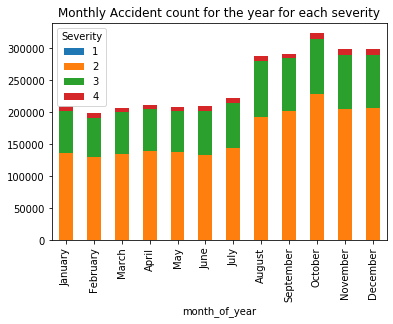

In [27]:
# Monthly Accident count showing how distribution of accidents on 12 months of the year

month_lst = ['January','February','March','April','May','June','July','August','September','October','November','December']
Us_acci_pd.groupby(['Severity', 'month_of_year']).size().reset_index().pivot(columns='Severity', index='month_of_year', values=0).reindex(month_lst).plot(kind='bar', stacked=True, title='Monthly Accident count for the year for each severity',)
display()

### 周末的事故数明显少于工作日，这可能是人们都在休息所以外出的机会少

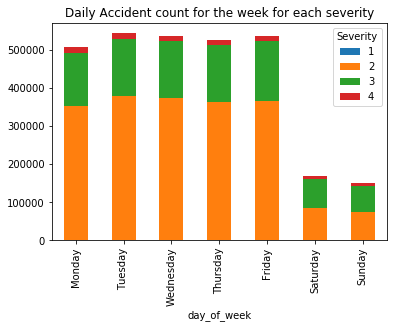

In [28]:
# Daily Accident count showing how distribution of accidents on 7 days of the week

weekday_lst = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
Us_acci_pd.groupby(['Severity', 'day_of_week']).size().reset_index().pivot(columns='Severity', index='day_of_week',values=0).reindex(weekday_lst).plot(kind='bar', stacked=True,title='Daily Accident count for the week for each severity')
display()

In [29]:
# Day light savings in USA bi-annually for the weeks 11 and 45 rise is seen as compared to previous weeks 10 & 44 for March & November respectively

col = ['10','11','12','44','45','46']
newcol = Us_acci_pd[Us_acci_pd.week_of_year.isin(col)]

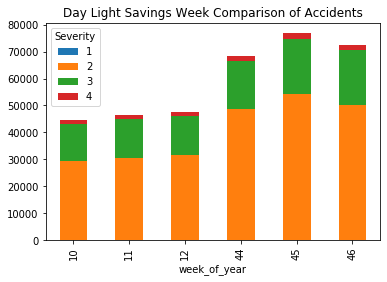

In [30]:
# For Day light Savings checking
day_acci = newcol.groupby(['Severity', 'week_of_year']).size().reset_index().pivot(columns='Severity', index='week_of_year', values=0).plot(kind='bar', stacked=True,title='Day Light Savings Week Comparison of Accidents')
display(day_acci)

In [31]:
subset=['Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight']

In [32]:
subset.remove("Turning_Loop")

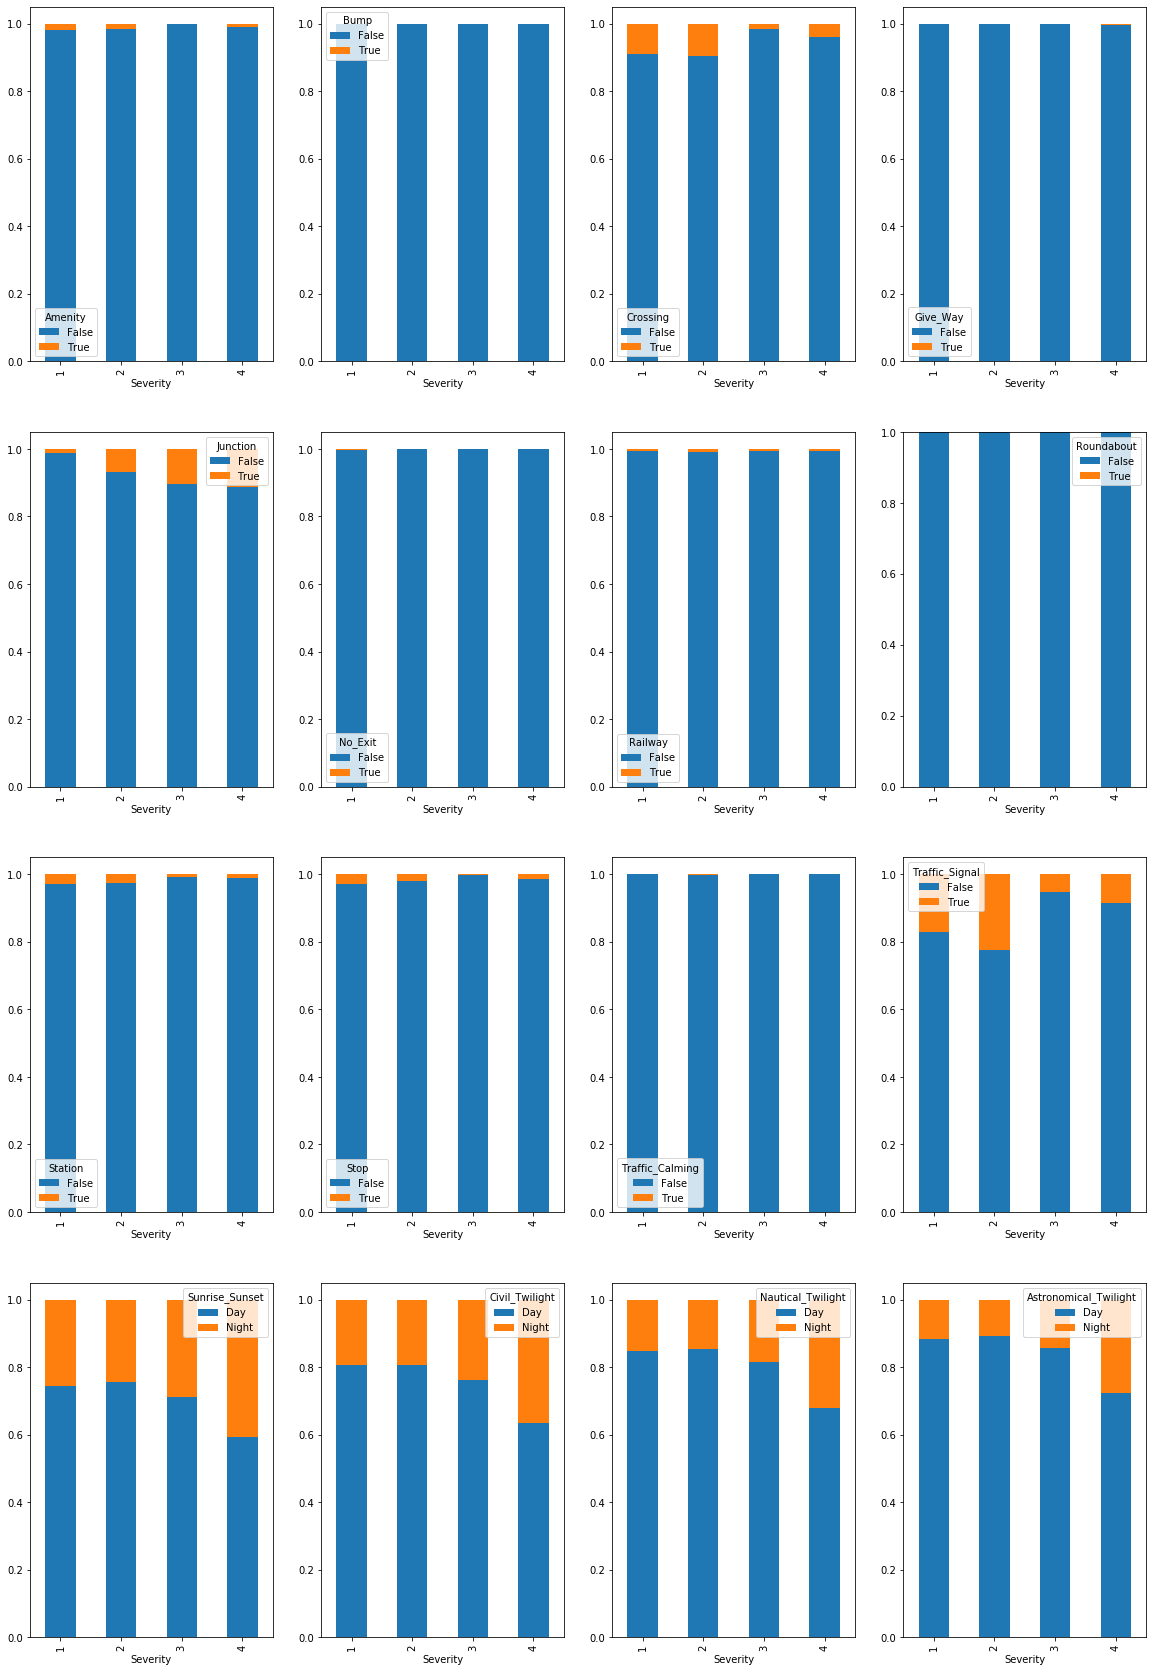

In [33]:
# Severity as a percentage on y axis showing how severe the accidents can be considering the various variables 

fig,ax=plt.subplots(4,4,figsize=(20,30))
for i in range(len(subset)):
    df_plot = Us_acci_pd.groupby([subset[i], "Severity"]).size().reset_index().pivot(columns=subset[i], index="Severity", values=0)
    df_plot.div(df_plot.sum(axis=1), axis=0).plot(kind='bar', stacked=True,ax=ax[int(i/4),i-int(i/4)*4])
display()

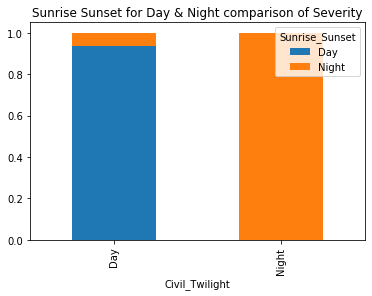

In [34]:
# Sunrise Sunset for Day & Night comparison of Severity 

df_plot = Us_acci_pd.groupby(["Sunrise_Sunset","Civil_Twilight"]).size().reset_index().pivot(columns="Sunrise_Sunset", index= "Civil_Twilight", values=0)
display(df_plot.div(df_plot.sum(axis=1), axis=0).plot(kind='bar', stacked=True,title='Sunrise Sunset for Day & Night comparison of Severity'))

### 从下图可以看出东部的事故率较高，严重的事故也比较多，这是因为美国东部比较发达，私家车的数量多

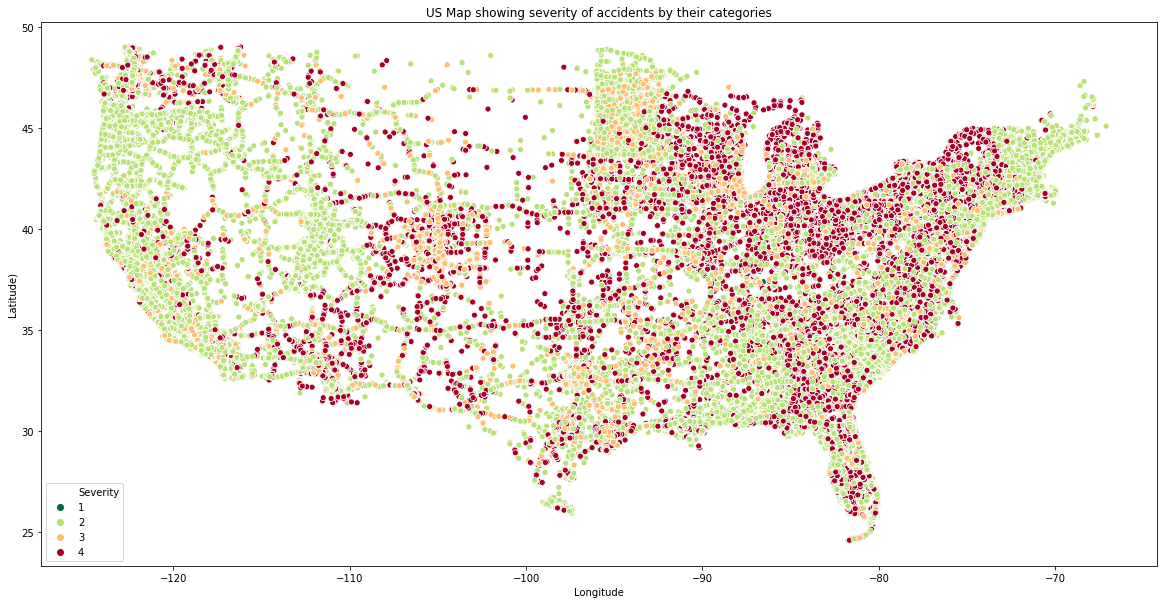

In [35]:
fig,ax=plt.subplots(1,figsize=(20,10))
sns.scatterplot(x='Start_Lng', y='Start_Lat', data=Us_acci_pd, hue='Severity',palette='RdYlGn_r',ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude)')
ax.set_title('US Map showing severity of accidents by their categories')
plt.show()

### 从下图可以看出在早上7，8点和晚上4，5点的事故数比较多，这可能是因为上下班的原因

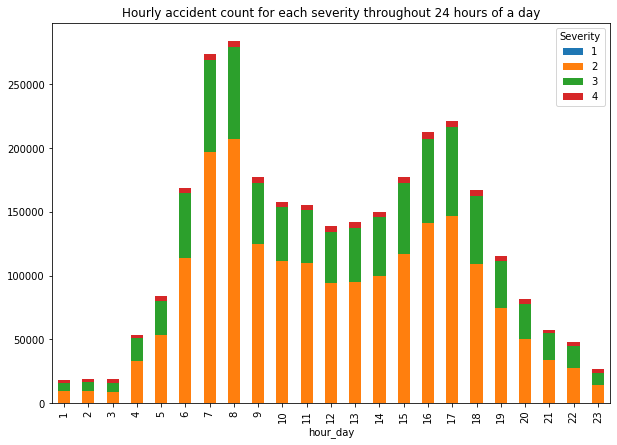

In [36]:
# Accident count showing how distribution of accidents on each hour days of the day for the whole 24 hours

hour_lst = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']

Us_acci_pd.groupby(['Severity', 'hour_day']).size().reset_index().pivot(columns='Severity', index='hour_day', values=0).reindex(hour_lst).plot(kind='bar', stacked=True,figsize=(10,7),title='Hourly accident count for each severity throughout 24 hours of a day');

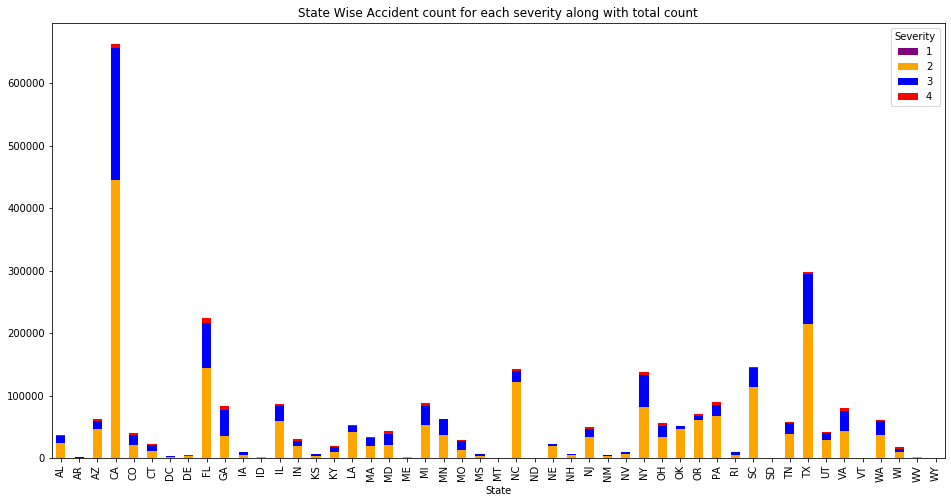

In [37]:
# Accidents count by each state and for each state count by severity of accidents
pd.crosstab(columns=Us_acci_pd['Severity'],
    index=Us_acci_pd['State']).plot(kind='bar',stacked=True,figsize=(16,8),color=['purple','orange','blue','red','green'],title='State Wise Accident count for each severity along with total count');

### 2级严重度的事故最多

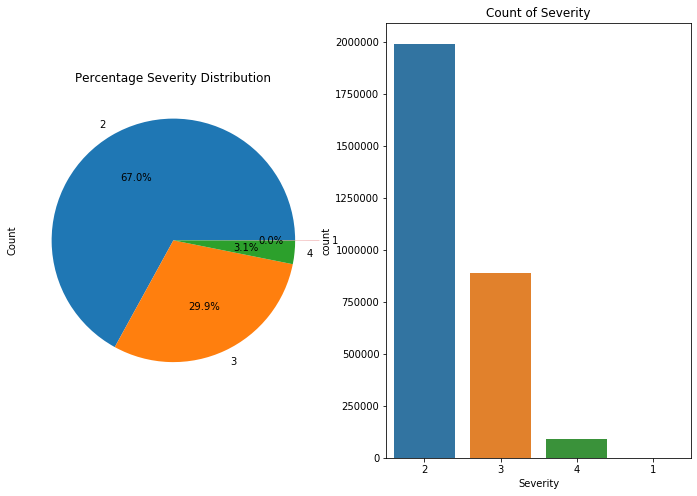

In [38]:
# Percent of severity
f,ax=plt.subplots(1,2,figsize=(12,8))
Us_acci_pd['Severity'].value_counts().plot.pie(explode=[0,0,0,0.2],autopct='%1.1f%%',ax=ax[0],shadow=False)
ax[0].set_title('Percentage Severity Distribution')
ax[0].set_ylabel('Count')
sns.countplot('Severity',data=Us_acci_pd,ax=ax[1],order=Us_acci_pd['Severity'].value_counts().index)
ax[1].set_title('Count of Severity')
plt.show()

### 以下10个州中事故数最多

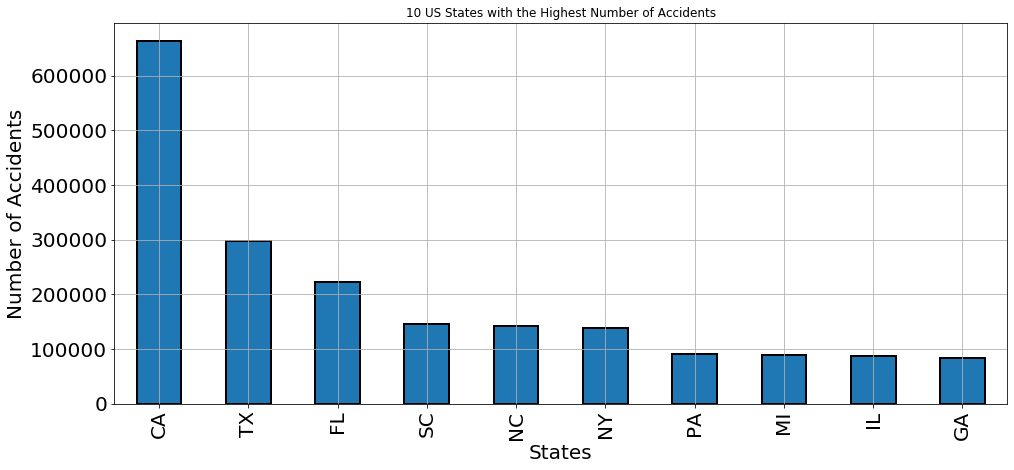

In [39]:
# plot a bar plot to visualize to see which states have the highest number of accidents
top_ten_cities = Us_acci_pd['State'].value_counts().head(10)
top_ten_cities.plot.bar(width=0.5,edgecolor='k',align='center',linewidth=2,title='10 US States with the Highest Number of Accidents',figsize=(16,7))
plt.xlabel('States',fontsize=20)
plt.ylabel('Number of Accidents',fontsize=20)
plt.tick_params(labelsize=20)
plt.grid()

## 以下城市中出现事故数最多

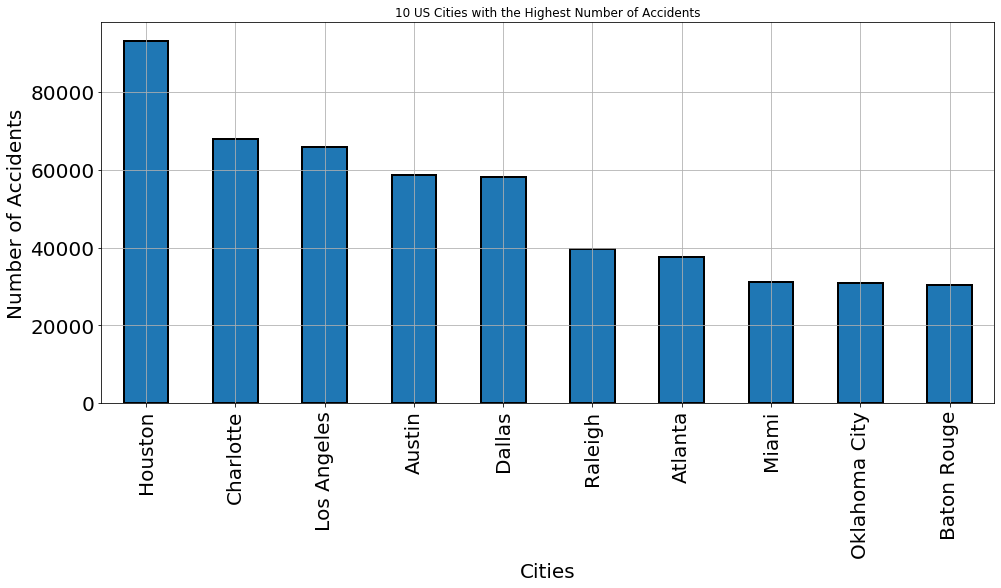

In [40]:
# plot a bar plot to visualize to see which cities have the highest number of accidents
top_ten_cities = Us_acci_pd['City'].value_counts().head(10)
top_ten_cities.plot.bar(width=0.5,edgecolor='k',align='center',linewidth=2,title='10 US Cities with the Highest Number of Accidents',figsize=(16,7))
plt.xlabel('Cities',fontsize=20)
plt.ylabel('Number of Accidents',fontsize=20)
plt.tick_params(labelsize=20)
plt.grid()

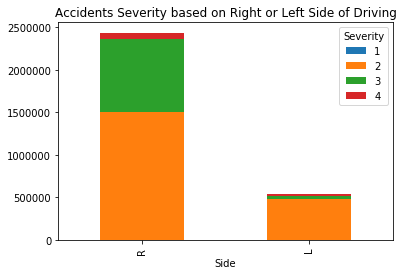

In [41]:
# Accidents based on the side of the driving Left & Right USA Right side driving 

Side_lst = ['R','L']
display(Us_acci_pd.groupby(['Severity', 'Side']).size().reset_index().pivot(columns='Severity', index='Side',values=0).reindex(Side_lst).plot(kind='bar', stacked=True,title='Accidents Severity based on Right or Left Side of Driving'))

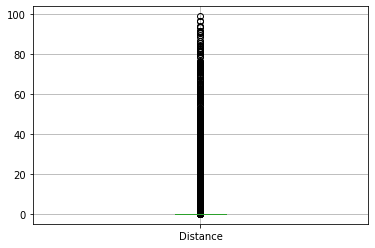

In [42]:
display(Us_acci_pd.boxplot(column=['Distance']))

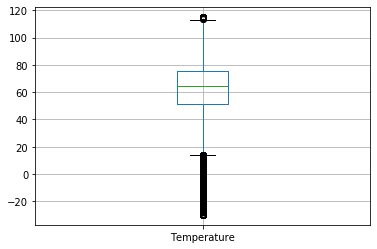

In [43]:
display(Us_acci_pd.boxplot(column=['Temperature']))

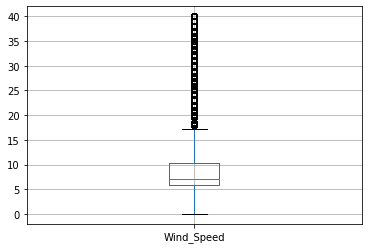

In [44]:
display(Us_acci_pd.boxplot(column=['Wind_Speed']))

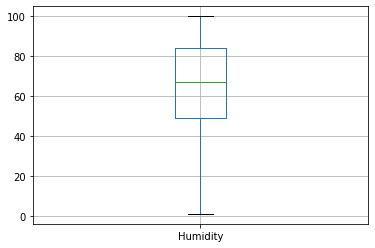

In [45]:
display(Us_acci_pd.boxplot(column=['Humidity']))

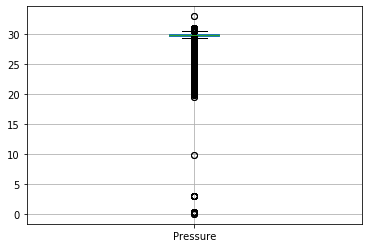

In [46]:
display(Us_acci_pd.boxplot(column=['Pressure']))

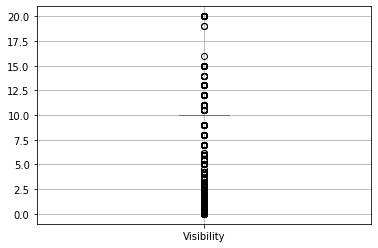

In [47]:
display(Us_acci_pd.boxplot(column=['Visibility']))

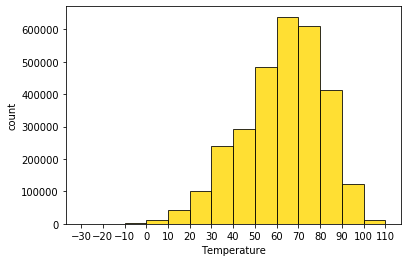

None

In [48]:
# Univariate histogram of Temp 

var = 'Temperature'
x = Us_acci_pd[var]

bins = np.arange(-30, 120,10.0)

plt.hist(x, bins, alpha=0.8, histtype='bar', color='gold',
         ec='black')

plt.xlabel(var)
plt.ylabel('count')
plt.xticks(bins)
display(plt.show())


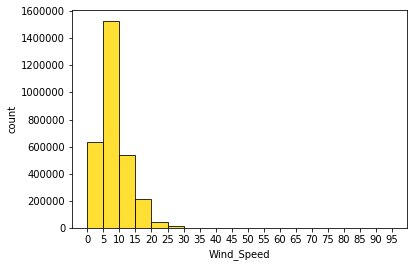

In [49]:
# Univariate Analysis of Wind_Speed

var = 'Wind_Speed'
x = Us_acci_pd[var]

bins = np.arange(0, 100,5.0)

plt.hist(x, bins, alpha=0.8, histtype='bar', color='gold',
         ec='black')

plt.xlabel(var)
plt.ylabel('count')
plt.xticks(bins)
plt.show()

In [50]:
Us_acci_pd.to_csv("Us_clean.csv",header=True,index=False)